# 0.Setup

In [ ]:
from google.colab import drive 
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/MyDrive/BME/TA/AI4Healthcare-sem1-2021-2022/TA-sessions/Ses-3"

/content/gdrive/MyDrive/BME/TA/AI4Healthcare-sem1-2021-2022/TA-sessions/Ses-3


In [ ]:
from scipy.io import loadmat
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.layers import (Activation, Conv2D, MaxPooling2D,
                                     Dropout, Input, Conv2DTranspose, concatenate, 
                                     Cropping2D, ZeroPadding2D)

### 1. Dataset

In [ ]:
dataset_file = os.path.join("Dataset", "imdbOCTwithLabels.mat")

In [ ]:
def create_dataset(paths):
  mat_contents  = loadmat(paths)
  imb = mat_contents['imdbOCTwithLabels'] 
  inputs = imb[0,0]['images']['data'][0,0]
  # transpose the shape with --> (N, H, W, C)
  inputs = np.transpose(inputs, (3, 2, 0, 1))
  outputs = imb[0,0]['images']['layerLabels_Exp1'][0,0]
  # transpose the shape with --> (N, H, W, C)
  outputs = np.transpose(outputs, (3, 2, 0, 1))
  outputs = outputs - 1
  return inputs, outputs

In [ ]:
data, labels = create_dataset(os.path.join("Dataset", "imdbOCTwithLabels.mat"))

In [ ]:
data.shape, labels.shape

((110, 1, 512, 768), (110, 1, 512, 768))

In [ ]:
print(f"Number of images = {data.shape[0]}")
print(f"Channel = {data.shape[1]}")
print(f"Height = {data.shape[2]}")
print(f"Width = {data.shape[3]}")

Number of images = 110
Channel = 1
Height = 512
Width = 768


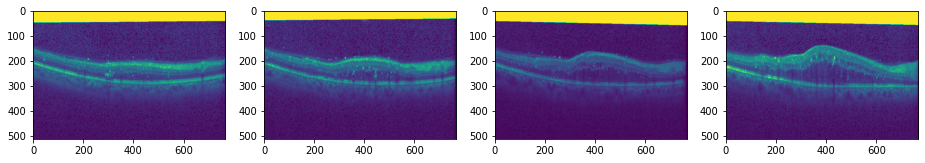

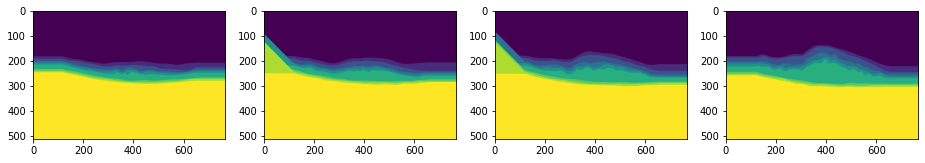

In [ ]:
plt.figure(figsize = (20,10))
for i in range(4):
  plt.subplot(1,5,i+1)
  plt.imshow(data[i][0])
plt.show()

plt.figure(figsize = (20,10))
for i in range(4):
  plt.subplot(1,5,i+1)
  plt.imshow(labels[i][0])
plt.show()

In [ ]:
num_classes = len(np.unique(labels))
list_classes = np.unique(labels)
print(f"labels.shape = {labels.shape}")
print(f"num_classes = {num_classes} with classes = {list_classes}")

labels.shape = (110, 1, 512, 768)
num_classes = 9 with classes = [0. 1. 2. 3. 4. 5. 6. 7. 8.]


In [ ]:
def convert_the_mask(n_classes, mask_input):
  # input: numpy_array with shape (N, C = 1, H, W)
  # output numpy_array wiht shape (N, C = n_classes, H, W)
  
  # change the shape --> (N, H, W)
  mask_input_new = np.squeeze(mask_input, axis = 1)

  # label_encoder the mask --> change the shape --> (N, H, W, n_classes)
  mask_input_new = to_categorical(mask_input_new, num_classes = n_classes)

  # change the shape again
  mask_input_new = np.transpose(mask_input_new, (0, 3, 1, 2))
  return mask_input_new

In [ ]:
labels_new = convert_the_mask(n_classes= num_classes, mask_input = labels)
print(f"labels_new.shape = {labels_new.shape}")

labels_new.shape = (110, 9, 512, 768)


+ train-val split

In [ ]:
percentage_of_train = 0.7 # # split 70 - 30 
look_back = int(round(data.shape[0]*percentage_of_train, 0))
trainx, trainy = data[:look_back], labels_new[:look_back]
testx, testy = data[look_back:], labels_new[look_back:]

print(f"trainx.shape = {trainx.shape} with trainy.shape = {trainy.shape}")
print(f"testx.shape = {testx.shape} with testy.shape = {testy.shape}")

trainx.shape = (77, 1, 512, 768) with trainy.shape = (77, 9, 512, 768)
testx.shape = (33, 1, 512, 768) with testy.shape = (33, 9, 512, 768)


+ convert to keras format and convert to tensor

In [ ]:
# return tensorflow format --> N, H, W, C
# tensorflow --> get channel last 

trainx = np.transpose(trainx, (0,2,3,1))
trainy = np.transpose(trainy, (0,2,3,1))
testx = np.transpose(testx, (0,2,3,1))
testy = np.transpose(testy, (0,2,3,1))

# convert to tensor
trainx = tf.convert_to_tensor(trainx)
trainy = tf.convert_to_tensor(trainy)
testx = tf.convert_to_tensor(testx)
testy = tf.convert_to_tensor(testy)

print(f"trainx.shape = {trainx.shape} and trainy.shape = {trainy.shape} with type = {type(trainx)}")
print(f"testx.shape = {testx.shape} and testy.shape = {testy.shape} with type = {type(testx)}")

trainx.shape = (77, 512, 768, 1) and trainy.shape = (77, 512, 768, 9) with type = <class 'tensorflow.python.framework.ops.EagerTensor'>
testx.shape = (33, 512, 768, 1) and testy.shape = (33, 512, 768, 9) with type = <class 'tensorflow.python.framework.ops.EagerTensor'>


### 2. Create model

In [ ]:
# constant
IMG_HEIGHT = 512
IMG_WIDTH = 768

IMG_CHANNELS = 1
NUM_CLASSES = num_classes

In [ ]:
# Unet Structure
def Model_UNet_Paper(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES):
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  c1 = tf.keras.layers.Conv2D(16, (3,3), activation= "relu", 
                              kernel_initializer= "he_normal", padding = "same")(inputs) 
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3,3), activation= "relu", 
                              kernel_initializer= "he_normal", padding = "same")(c1) 
  p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3,3), padding = "same", activation = "relu", kernel_initializer= "he_normal")(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3,3), padding = "same", activation = "relu", kernel_initializer= "he_normal")(c2)
  p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

  c3 = tf.keras.layers.Conv2D(64, (3,3), padding = "same", activation= "relu", kernel_initializer= "he_normal")(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3,3), padding = "same", activation = "relu", kernel_initializer= "he_normal")(c3)

  p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

  c4 = tf.keras.layers.Conv2D(128, (3,3), padding = "same", activation = "relu", kernel_initializer= "he_normal")(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3,3), padding = "same", activation = "relu", kernel_initializer= "he_normal")(c4)

  p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

  c5 = tf.keras.layers.Conv2D(256, (3,3), padding = "same", activation = "relu", kernel_initializer= "he_normal")(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3,3), padding = "same", activation = "relu", kernel_initializer= "he_normal")(c5)

  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(c9)
  final_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  return final_model

### 3. Start train model (Cross_entropy + Accuracy)

In [ ]:
model = Model_UNet_Paper(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES)

In [ ]:
# compile and display model
model.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy']) 

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 768, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 768, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 768, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# create callbacks and checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint("Checkpoint_Unet_normal.h5", verbose = 1,  # to display on the screen
                                                  save_best_only =  True)
callbacks = [checkpointer, 
             tf.keras.callbacks.EarlyStopping(patience = 2, monitor= "val_loss")]

In [ ]:
result = model.fit(trainx, trainy,
                   epochs = 80, batch_size = 6, 
                   validation_data = (testx, testy), 
                   callbacks = callbacks)

Epoch 1/80
13/13 [==============================] - ETA: 0s - loss: 2.0611 - accuracy: 0.4078
Epoch 00001: val_loss improved from inf to 1.83288, saving model to Checkpoint_Unet_normal.h5
13/13 [==============================] - 46s 2s/step - loss: 2.0611 - accuracy: 0.4078 - val_loss: 1.8329 - val_accuracy: 0.5523
Epoch 2/80
13/13 [==============================] - ETA: 0s - loss: 1.4919 - accuracy: 0.5464
Epoch 00002: val_loss improved from 1.83288 to 1.36644, saving model to Checkpoint_Unet_normal.h5
13/13 [==============================] - 14s 1s/step - loss: 1.4919 - accuracy: 0.5464 - val_loss: 1.3664 - val_accuracy: 0.5519
Epoch 3/80
13/13 [==============================] - ETA: 0s - loss: 1.1211 - accuracy: 0.5569
Epoch 00003: val_loss improved from 1.36644 to 1.01989, saving model to Checkpoint_Unet_normal.h5
13/13 [==============================] - 14s 1s/step - loss: 1.1211 - accuracy: 0.5569 - val_loss: 1.0199 - val_accuracy: 0.5553
Epoch 4/80
13/13 [=======================

In [ ]:
test_predicts = model.predict(testx)
print(f"test_predicts.shape = {test_predicts.shape}")

# convert 
test_predicts_argmax = np.argmax(test_predicts, axis = 3) 
print(f"test_predicts_argmax = {test_predicts_argmax.shape}")

test_predicts.shape = (33, 512, 768, 9)
test_predicts_argmax = (33, 512, 768)


In [ ]:
trainx_plot, trainy_plot = data[:look_back], labels[:look_back]
testx_plot, testy_plot = data[look_back:], labels[look_back:]

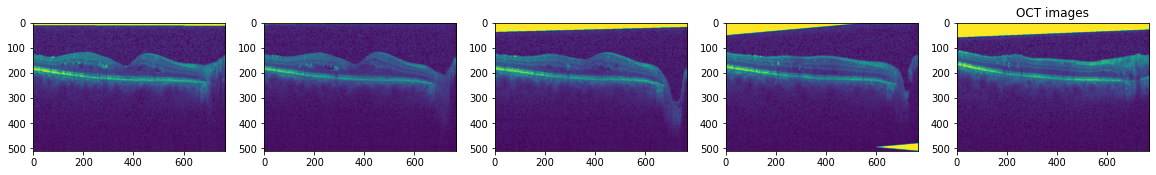

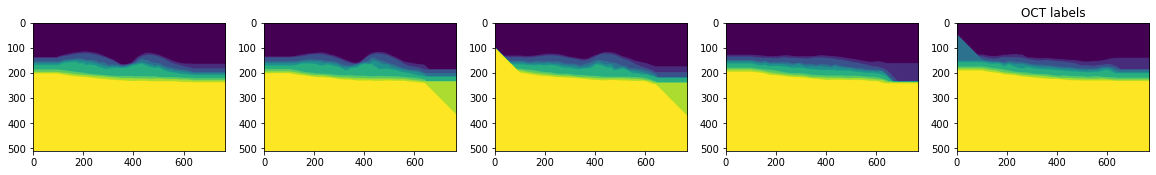

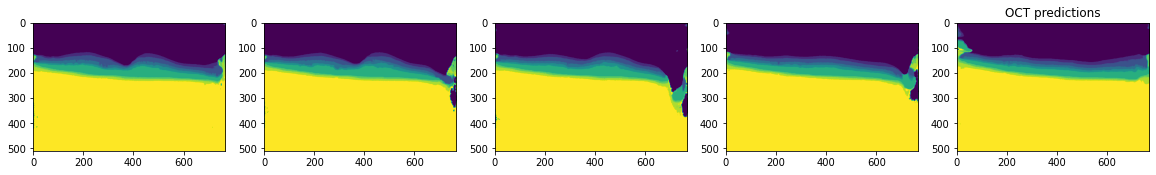

In [ ]:
plt.figure(figsize = (20,10))
for i in range(5,10):
  j = i - 5
  plt.subplot(1,5,j+1)
  plt.imshow(testx_plot[i][0])
plt.title("OCT images")
plt.show()

plt.figure(figsize = (20,10))
for i in range(5,10):
  j = i - 5
  plt.subplot(1,5,j+1)
  plt.imshow(testy_plot[i][0])
plt.title("OCT labels")
plt.show()

plt.figure(figsize = (20,10))
for i in range(5,10):
  j = i - 5
  plt.subplot(1,5,j+1)
  plt.imshow(test_predicts_argmax[i])
plt.title("OCT predictions")
plt.show()

### 4. Start train model (Dice loss + Dice coefficient)

In [ ]:
def dice_coefficient(y_true, y_pred, axis = (0,1), epsilon = 1e-5):
  '''
  - y_true (tensor): tensor of labels for all classes with shape (H, W, num_classes)
  - y_pred (tensor): tensor of predictions for all classes with shape (H, W, num_classes)
  '''

  dice_numerator = 2 * K.sum((y_true * y_pred), axis = axis) + epsilon
  dice_denominator = K.sum(y_true, axis = axis) + K.sum(y_pred, axis = axis) + epsilon
  dice_coefficient = K.mean((dice_numerator / dice_denominator), axis = 0)
  return dice_coefficient

In [ ]:
def soft_dice_loss(y_true, y_pred, axis = (0,1), epsilon = 1e-5):
  '''
  - y_true (tensor): tensor of labels for all classes with shape (H, W, num_classes)
  - y_pred (tensor): tensor of predictions for all classes with shape (H, W, num_classes)
  '''

  dice_numerator = 2 * K.sum((y_true * y_pred), axis = axis) + epsilon
  dice_denominator = K.sum((y_true ** 2), axis = axis) + K.sum((y_pred ** 2), axis = axis) + epsilon
  dice_loss =  1 - K.mean((dice_numerator / dice_denominator))
  return dice_loss

In [ ]:
model_1 = Model_UNet_Paper(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES)
model_1.compile(optimizer='adam', loss= soft_dice_loss, metrics=[dice_coefficient])

In [ ]:
# create callbacks and checkpoint
checkpointer_1 = tf.keras.callbacks.ModelCheckpoint("Checkpoint_Unet_dice.h5", verbose = 1,  # to display on the screen
                                                  save_best_only =  True)
callbacks = [checkpointer_1, 
             tf.keras.callbacks.EarlyStopping(patience = 2, monitor= "val_loss")]

In [ ]:
result = model_1.fit(trainx,trainy, epochs = 80, batch_size = 6, 
                     validation_data = (testx, testy), callbacks = callbacks)

Epoch 1/80
13/13 [==============================] - ETA: 0s - loss: 0.8465 - dice_coefficient: 0.0691
Epoch 00001: val_loss improved from inf to 0.84572, saving model to Checkpoint_Unet_dice.h5
13/13 [==============================] - 18s 1s/step - loss: 0.8465 - dice_coefficient: 0.0691 - val_loss: 0.8457 - val_dice_coefficient: 0.0689
Epoch 2/80
13/13 [==============================] - ETA: 0s - loss: 0.8173 - dice_coefficient: 0.0900
Epoch 00002: val_loss improved from 0.84572 to 0.77412, saving model to Checkpoint_Unet_dice.h5
13/13 [==============================] - 14s 1s/step - loss: 0.8173 - dice_coefficient: 0.0900 - val_loss: 0.7741 - val_dice_coefficient: 0.1191
Epoch 3/80
13/13 [==============================] - ETA: 0s - loss: 0.7515 - dice_coefficient: 0.1509
Epoch 00003: val_loss improved from 0.77412 to 0.70743, saving model to Checkpoint_Unet_dice.h5
13/13 [==============================] - 14s 1s/step - loss: 0.7515 - dice_coefficient: 0.1509 - val_loss: 0.7074 - val_

In [ ]:
test_predicts = model_1.predict(testx)
print(f"test_predicts.shape = {test_predicts.shape}")
# convert 
test_predicts_argmax = np.argmax(test_predicts, axis = 3) 
print(f"test_predicts_argmax = {test_predicts_argmax.shape}")

test_predicts.shape = (33, 512, 768, 9)
test_predicts_argmax = (33, 512, 768)


In [ ]:
trainx_plot, trainy_plot = data[:look_back], labels[:look_back]
testx_plot, testy_plot = data[look_back:], labels[look_back:]

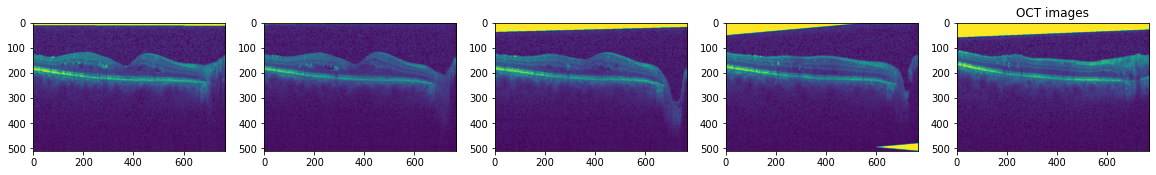

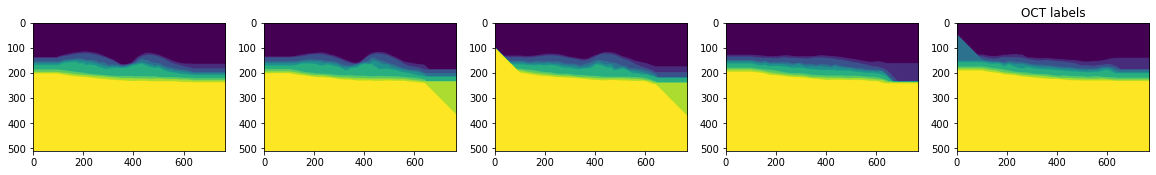

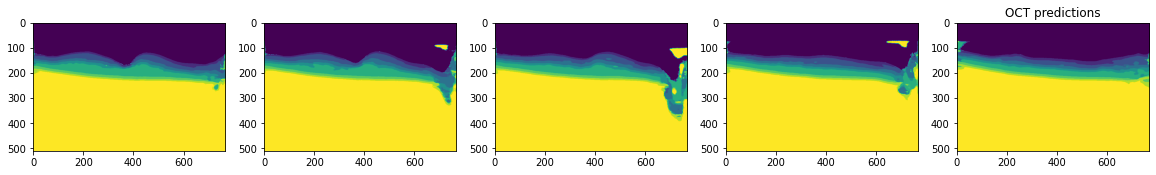

In [ ]:
plt.figure(figsize = (20,10))
for i in range(5,10):
  j = i - 5
  plt.subplot(1,5,j+1)
  plt.imshow(testx_plot[i][0])
plt.title("OCT images")
plt.show()

plt.figure(figsize = (20,10))
for i in range(5,10):
  j = i - 5
  plt.subplot(1,5,j+1)
  plt.imshow(testy_plot[i][0])
plt.title("OCT labels")
plt.show()

plt.figure(figsize = (20,10))
for i in range(5,10):
  j = i - 5
  plt.subplot(1,5,j+1)
  plt.imshow(test_predicts_argmax[i])
plt.title("OCT predictions")
plt.show()